In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r "/content/drive/MyDrive/aircraft/crop" "/content/dataset"

In [5]:
data_dir = '/content/dataset/'

filepaths = []
labels = []


folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)

    files = os.listdir(foldpath)
    for f in files:
        fpath = os.path.join(foldpath, f)

        filepaths.append(fpath)
        labels.append(fold)


data_dir = pd.DataFrame(data={'filepaths':filepaths, 'labels':labels})
data_dir

,filepaths,labels
0,/content/dataset/F16/04705e0911ce7e3dfebf94037...,F16
1,/content/dataset/F16/a8181fbce35cd6852c73f5426...,F16
2,/content/dataset/F16/68860c002b8727479d3f3c7e5...,F16
3,/content/dataset/F16/c206fa18ae8eff5507078acb4...,F16
4,/content/dataset/F16/483c0e5f489166bd7981b1c26...,F16
...,...,...
18183,/content/dataset/AV8B/3d1c9d4889c20d923acdfb62...,AV8B
18184,/content/dataset/AV8B/3cb7e6c902ccf5977ac1f58d...,AV8B
18185,/content/dataset/AV8B/e1b984e3574a8f5e099ce3e3...,AV8B
18186,/content/dataset/AV8B/1e88f60013b5ee45c71a1f18...,AV8B


In [6]:
train_df, temp_df = train_test_split(data_dir, test_size=0.3, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

In [7]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# Update ImageDataGenerators with the correct preprocessing function and target size 300x300
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNetB3 preprocessing
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(300, 300),  # Changed to 300x300
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16
)

valid_gen = valid_test_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(300, 300),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16
)

test_gen = valid_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(300, 300),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16
)

Found 12731 validated image filenames belonging to 27 classes.
Found 2728 validated image filenames belonging to 27 classes.
Found 2729 validated image filenames belonging to 27 classes.


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Sequential

base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(300, 300, 3),  # Updated shape
    pooling="max"
)

# Get number of classes dynamically from the generator
num_classes = len(train_gen.class_indices)

# Build your model
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,190,090 (42.69 MB)

 Trainable params: 11,099,715 (42.34 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [9]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6
)


In [10]:
model.compile(
    optimizer=Adamax(learning_rate=0.001),  # Reduced from 0.001
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,190,090 (42.69 MB)

 Trainable params: 11,099,715 (42.34 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [11]:
history=model.fit(train_gen,validation_data=valid_gen,epochs=20)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 536s 493ms/step - accuracy: 0.2522 - loss: 6.5433 - val_accuracy: 0.6859 - val_loss: 3.2318
Epoch 2/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 290s 364ms/step - accuracy: 0.6702 - loss: 2.9212 - val_accuracy: 0.8057 - val_loss: 1.6747
Epoch 3/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 281s 352ms/step - accuracy: 0.7824 - loss: 1.5722 - val_accuracy: 0.8519 - val_loss: 1.0011
Epoch 4/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 280s 351ms/step - accuracy: 0.8543 - loss: 0.9280 - val_accuracy: 0.8842 - val_loss: 0.7056
Epoch 5/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 277s 348ms/step - accuracy: 0.8868 - loss: 0.6586 - val_accuracy: 0.8889 - val_loss: 0.6127
Epoch 6/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 276s 347ms/step - accuracy: 0.9028 - loss: 0.5262 - val_accuracy: 0.9014 - val_loss: 0.5466
Epoch 7/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 274s 345ms/step - accuracy: 0.9151 - loss: 0.4618 - val_accuracy: 0.9091 - val_loss: 0.4921
Epoch 8/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 281s 352ms/step - accuracy: 0.9307 -

KeyboardInterrupt: 

In [15]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

Epochs = [i+1 for i in range(len(tr_acc))]

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'orange', label= 'Training loss')
plt.plot(Epochs, val_loss, label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'red', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'orange', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'red', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

NameError: name 'history' is not defined

In [16]:
train_score = model.evaluate(train_gen)
test_score = model.evaluate(test_gen)
# test_score = model.evaluate(test_gen)

pd.DataFrame({
    '': ['Loss','Accuracy'],
    'Train score': [train_score[0], f'{round(train_score[1] * 100, 2)}%'],
#     'Valid score': [valid_score[0], f'{round(valid_score[1] * 100, 2)}%']
    'Test score': [test_score[0], f'{round(test_score[1] * 100, 2)}%']})

796/796 ━━━━━━━━━━━━━━━━━━━━ 268s 337ms/step - accuracy: 0.9945 - loss: 0.1130
171/171 ━━━━━━━━━━━━━━━━━━━━ 34s 198ms/step - accuracy: 0.9194 - loss: 0.4266


,,Train score,Test score
0,Loss,0.11261,0.423807
1,Accuracy,99.36%,91.79%


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,389,522 (127.37 MB)

 Trainable params: 11,099,715 (42.34 MB)

 Non-trainable params: 90,375 (353.03 KB)

 Optimizer params: 22,199,432 (84.68 MB)

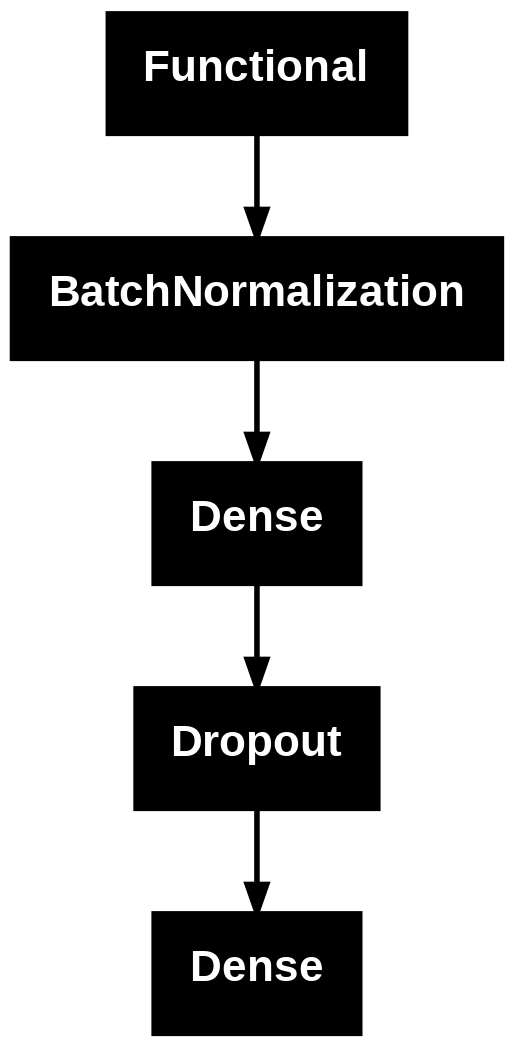

In [17]:
from keras.utils import plot_model
model.summary()
plot_model(model,to_file='model.png')

In [18]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.9116 - loss: 0.4572
Test Accuracy: 91.79%


171/171 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step


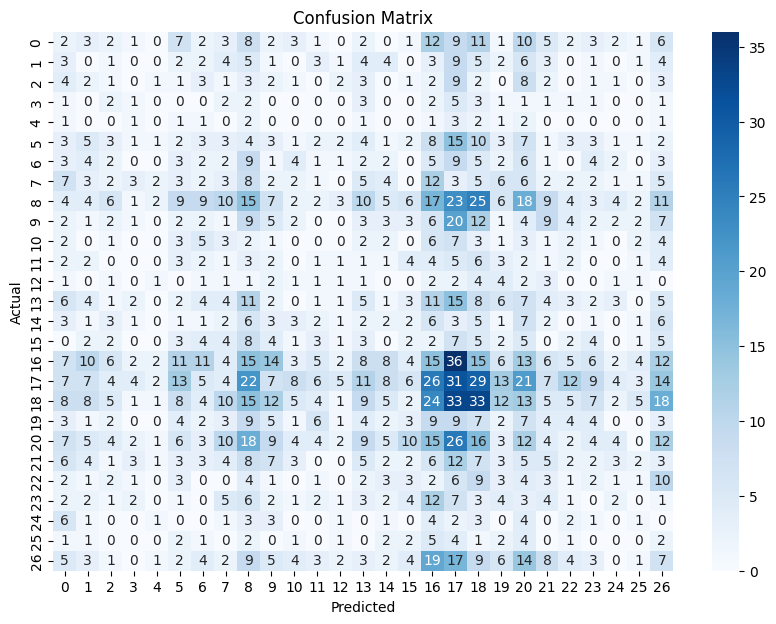

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get true labels & predictions
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot it
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [21]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


NameError: name 'history' is not defined

<Figure size 1000x500 with 0 Axes>

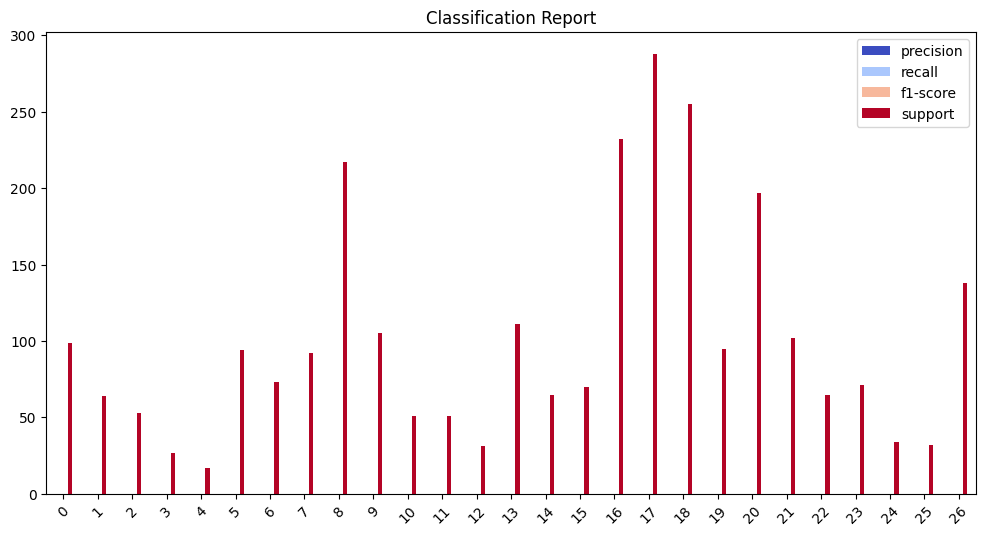

In [22]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred_classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plot Precision, Recall, and F1-score
df_report[:-3].plot(kind='bar', figsize=(12, 6), colormap='coolwarm')
plt.title('Classification Report')
plt.xticks(rotation=45)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


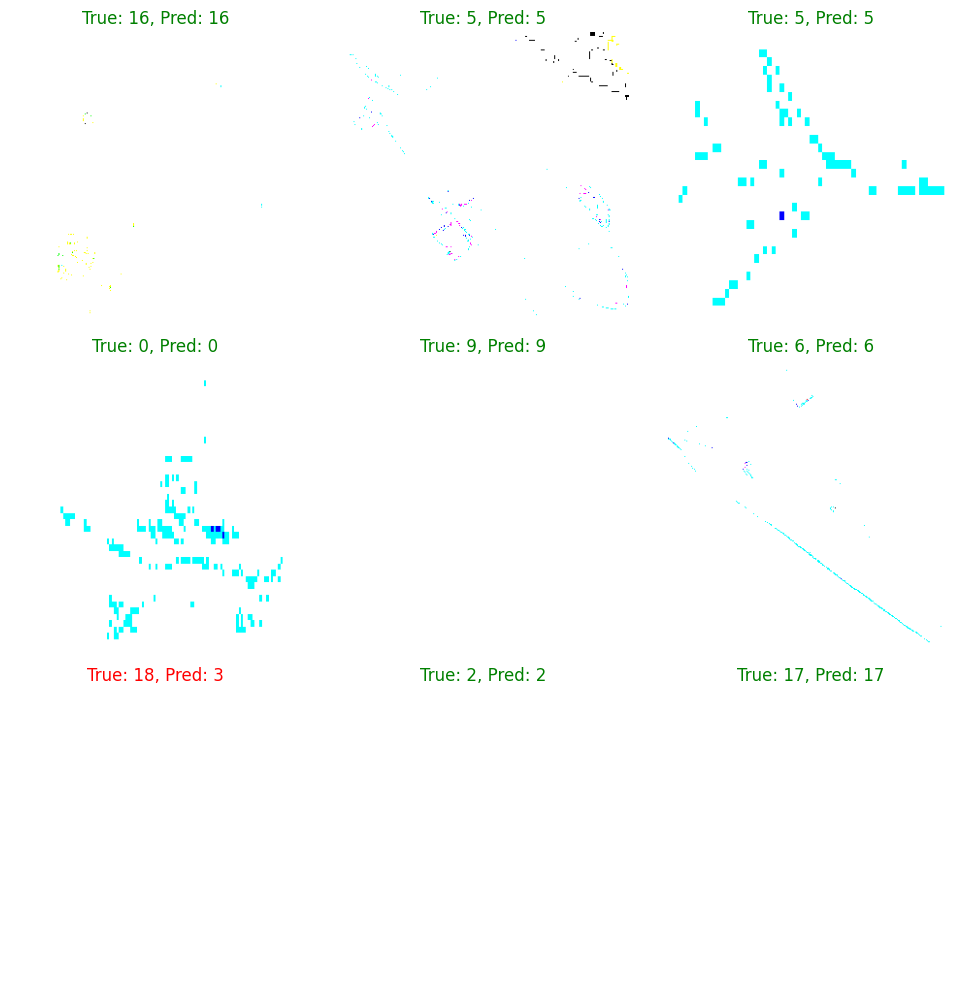

In [25]:
import random
from tensorflow.keras.preprocessing import image

# Get some test images
sample_images, sample_labels = next(test_gen)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    img = sample_images[i]
    true_label = np.argmax(sample_labels[i])
    pred_label = np.argmax(model.predict(img[np.newaxis, ...]))

    ax.imshow(img)
    ax.set_title(f'True: {true_label}, Pred: {pred_label}', color='green' if true_label == pred_label else 'red')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [26]:
model.save("model.keras")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,389,522 (127.37 MB)

 Trainable params: 11,099,715 (42.34 MB)

 Non-trainable params: 90,375 (353.03 KB)

 Optimizer params: 22,199,432 (84.68 MB)

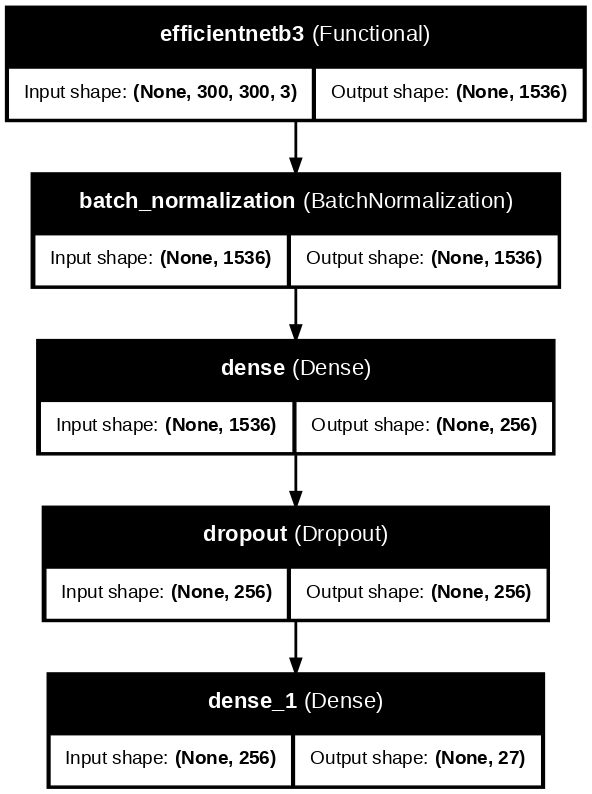

In [27]:
from tensorflow.keras.utils import plot_model  # Updated import for TensorFlow 2.x

# Display model summary
model.summary()

# Save and display model architecture with shapes
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True, dpi=100)

# (Optional) Display the saved model image inline if using Jupyter Notebook
from IPython.display import Image
Image("model.png")


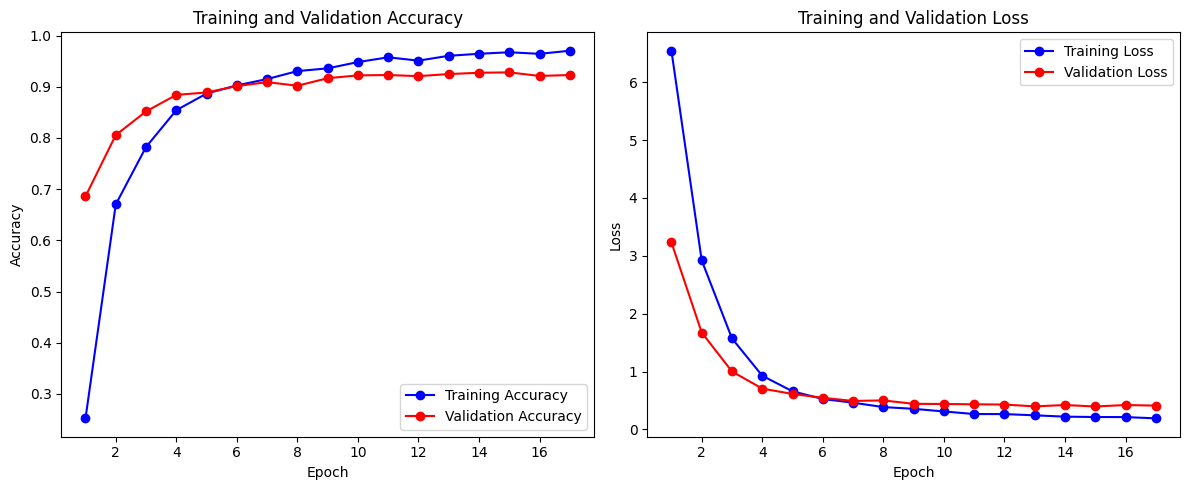

In [31]:
import matplotlib.pyplot as plt

# Create a history dictionary with the logged values.
# Update these lists with your actual training log values.
history = {
    "accuracy": [0.2522, 0.6702, 0.7824, 0.8543, 0.8868, 0.9028, 0.9151, 0.9307, 0.9360, 0.9483, 0.9576, 0.9511, 0.9606, 0.9645, 0.9675, 0.9644, 0.9705],
    "loss":     [6.5433, 2.9212, 1.5722, 0.9280, 0.6586, 0.5262, 0.4618, 0.3865, 0.3561, 0.3103, 0.2661, 0.2652, 0.2439, 0.2208, 0.2145, 0.2133, 0.1917],
    "val_accuracy": [0.6859, 0.8057, 0.8519, 0.8842, 0.8889, 0.9014, 0.9091, 0.9021, 0.9168, 0.9223, 0.9230, 0.9208, 0.9249, 0.9274, 0.9282, 0.9212, 0.9230],
    "val_loss": [3.2318, 1.6747, 1.0011, 0.7056, 0.6127, 0.5466, 0.4921, 0.5017, 0.4423, 0.4395, 0.4344, 0.4299, 0.3983, 0.4214, 0.3964, 0.4217, 0.4116]
}

# Determine the number of epochs that were run (here we have 17 epochs)
epochs = range(1, len(history["accuracy"]) + 1)

# Plotting Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history["accuracy"], "bo-", label="Training Accuracy")
plt.plot(epochs, history["val_accuracy"], "ro-", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history["loss"], "bo-", label="Training Loss")
plt.plot(epochs, history["val_loss"], "ro-", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()
